# Taurus Column density map

In [57]:
import aplpy
from astropy.io import fits
%pylab inline
#plt.style.use(['dark_background'])

Populating the interactive namespace from numpy and matplotlib


In [58]:
from pywavan import fan_trans, apodize, padding, depad, powspec, gauss_beam

INFO:astropy:Auto-setting vmin to -6.298e+20
INFO:astropy:Auto-setting vmax to  1.362e+22


INFO: Auto-setting vmin to -6.298e+20 [aplpy.core]
INFO: Auto-setting vmax to  1.362e+22 [aplpy.core]


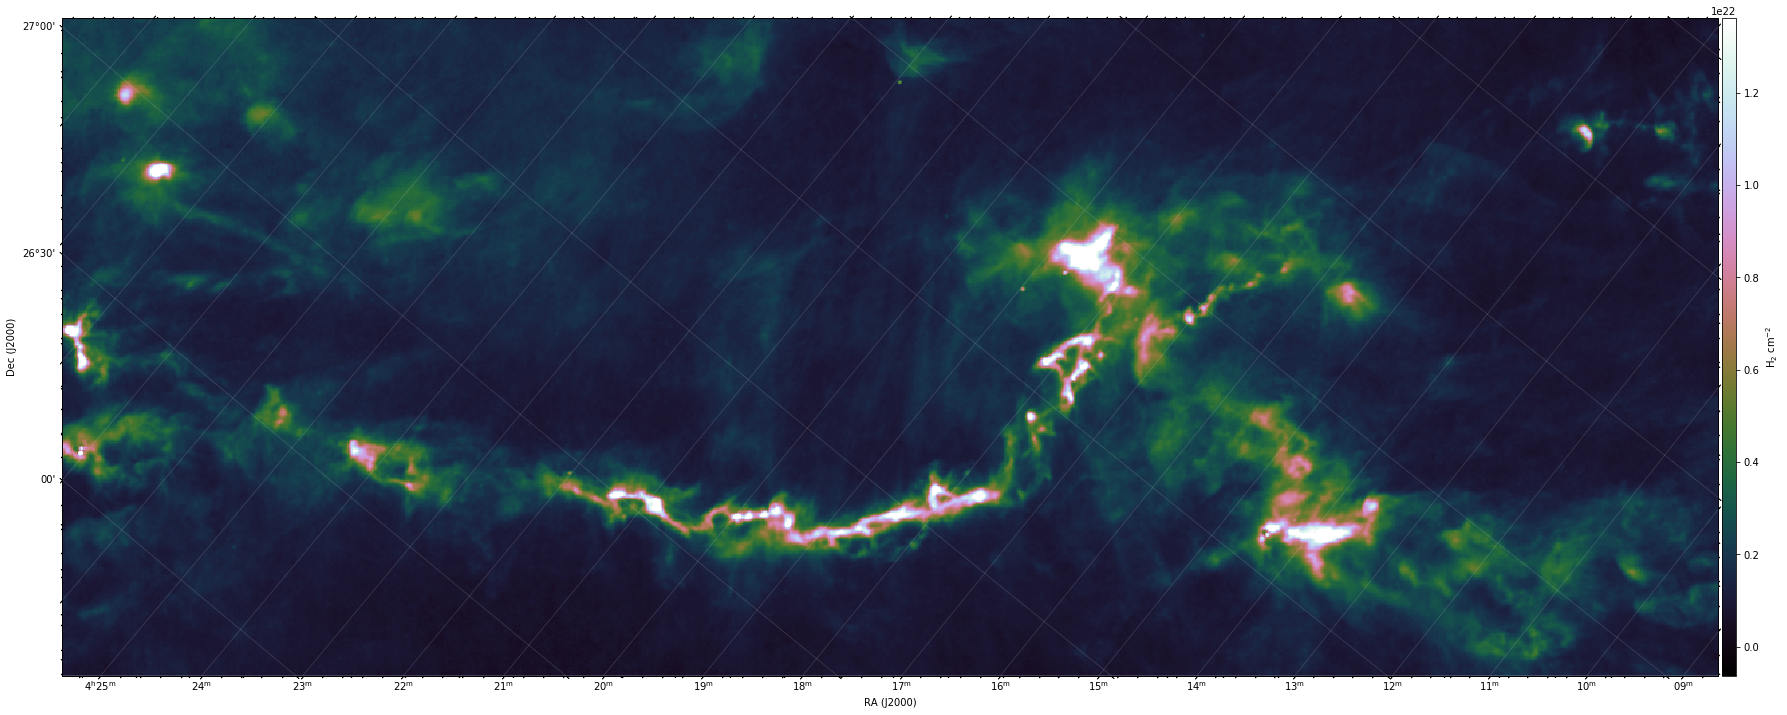

In [155]:
#Read map
plt.figure(1, figsize=(30,15))
figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/HGBS_taurus_L1495_column_density_map_rot40deg_cut_bin.fits'
#HDU = fits.open(figfile)
#im = HDU[0].data
#header = HDU[0].header

fig_all = plt.figure(1, figsize=(30,15))
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('hh:mm')
fig.tick_labels.set_yformat('dd:mm')
fig.ticks.set_xspacing(0.25)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

### Calculate the Fourier power spectrum

In [147]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
im /= 1e20
im[im > 150.] = 150.
imzm = im - np.mean(im)

#Apodization

tapper = apodize(nb,na,0.98)
imt = imzm *tapper
imr = padding(imt,1500,1500)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Beam Power spectrum
FWHM = 36.9 / (60.*reso)  #Beam size at 500 micron
beam = gauss_beam(FWHM,1500,1500,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation

Noise = np.mean(spec_k[(tab_k > 1.5) & (tab_k < 2.0)])

### Calculate the Wavelet Power Spectrum

In [148]:
#Beam Power spectrum
#FWHM = 18.2 / (60.*reso)  #Beam size at 250 micron
FWHM = 36.9 / (60.*reso)  #Beam size at 500 micron
beam = gauss_beam(FWHM,1500,1500,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation
Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False)
del Bwt,BS11a,Bq
BS1an = BS1a / BS1a[4]

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=0, qdyn=False, apodize= 0.98, arrdim = np.array([1500,1500]))

1500 1500


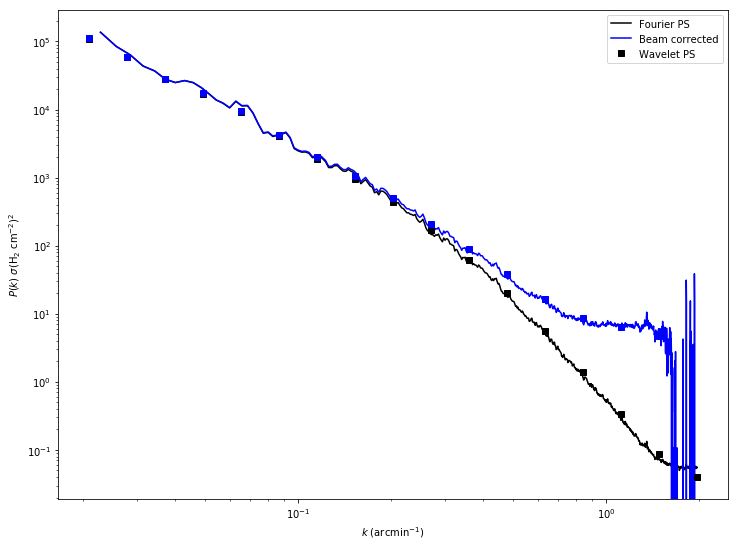

In [149]:
wl = 7 #Wavelet scale corresponding to half the smallest dimension
ws = 24
flim = np.where((tab_k > wav_k[wl]) & (tab_k < wav_k[ws-1]))

spec_kc = (spec_k - Noise) / spec_beamn
S1ac = (S1a - Noise) /  BS1an

plt.figure(figsize=(12,9))
plt.plot(tab_k[flim], spec_k[flim], color='black',label='Fourier PS', linewidth=1.5)
plt.plot(tab_k[flim], spec_kc[flim], color='blue',label='Beam corrected', linewidth=1.5)
plt.plot(wav_k[wl:ws], S1a[wl:ws],'s',color='black',label='Wavelet PS')
plt.plot(wav_k[wl:ws], S1ac[wl:ws],'s',color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$ (arcmin$^{-1}$)")
plt.ylabel(r"$P(k)$ $\sigma$(H$_2$ cm$^{-2}$)$^2$")
plt.legend()

In [150]:
#Set a list of q
q=[]
q=[2.9]*25
#print q

#Wavelet power spectrum
wts, S11as, wav_k, S1as, qs = fan_trans(imzm, reso=reso, q=q, qdyn=True, skewl=0.6, apodize= 0.98, arrdim = np.array([1500,1500]))

1500 1500


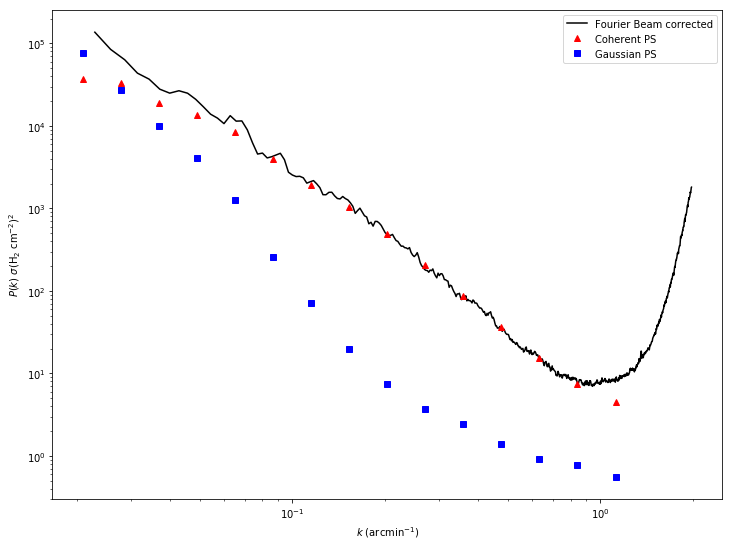

In [151]:
S1asc = (S1as - Noise) / BS1an

plt.figure(figsize=(12,9))
plt.plot(tab_k[flim], spec_k[flim]/spec_beamn[flim], color='black',label='Fourier Beam corrected', linewidth=1.5)
plt.plot(wav_k[wl:ws], S1asc[1,wl:ws],'^',color='red',label='Coherent PS')
plt.plot(wav_k[wl:ws], S1asc[2,wl:ws],'s',color='blue',label='Gaussian PS')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$ (arcmin$^{-1}$)")
plt.ylabel(r"$P(k)$ $\sigma$(H$_2$ cm$^{-2}$)$^2$")
plt.legend()

INFO:astropy:Auto-setting vmin to -1.647e+01
INFO:astropy:Auto-setting vmax to  2.904e+01


INFO: Auto-setting vmin to -1.647e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.904e+01 [aplpy.core]


INFO:astropy:Auto-setting vmin to -2.872e+01
INFO:astropy:Auto-setting vmax to  1.087e+02


INFO: Auto-setting vmin to -2.872e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.087e+02 [aplpy.core]


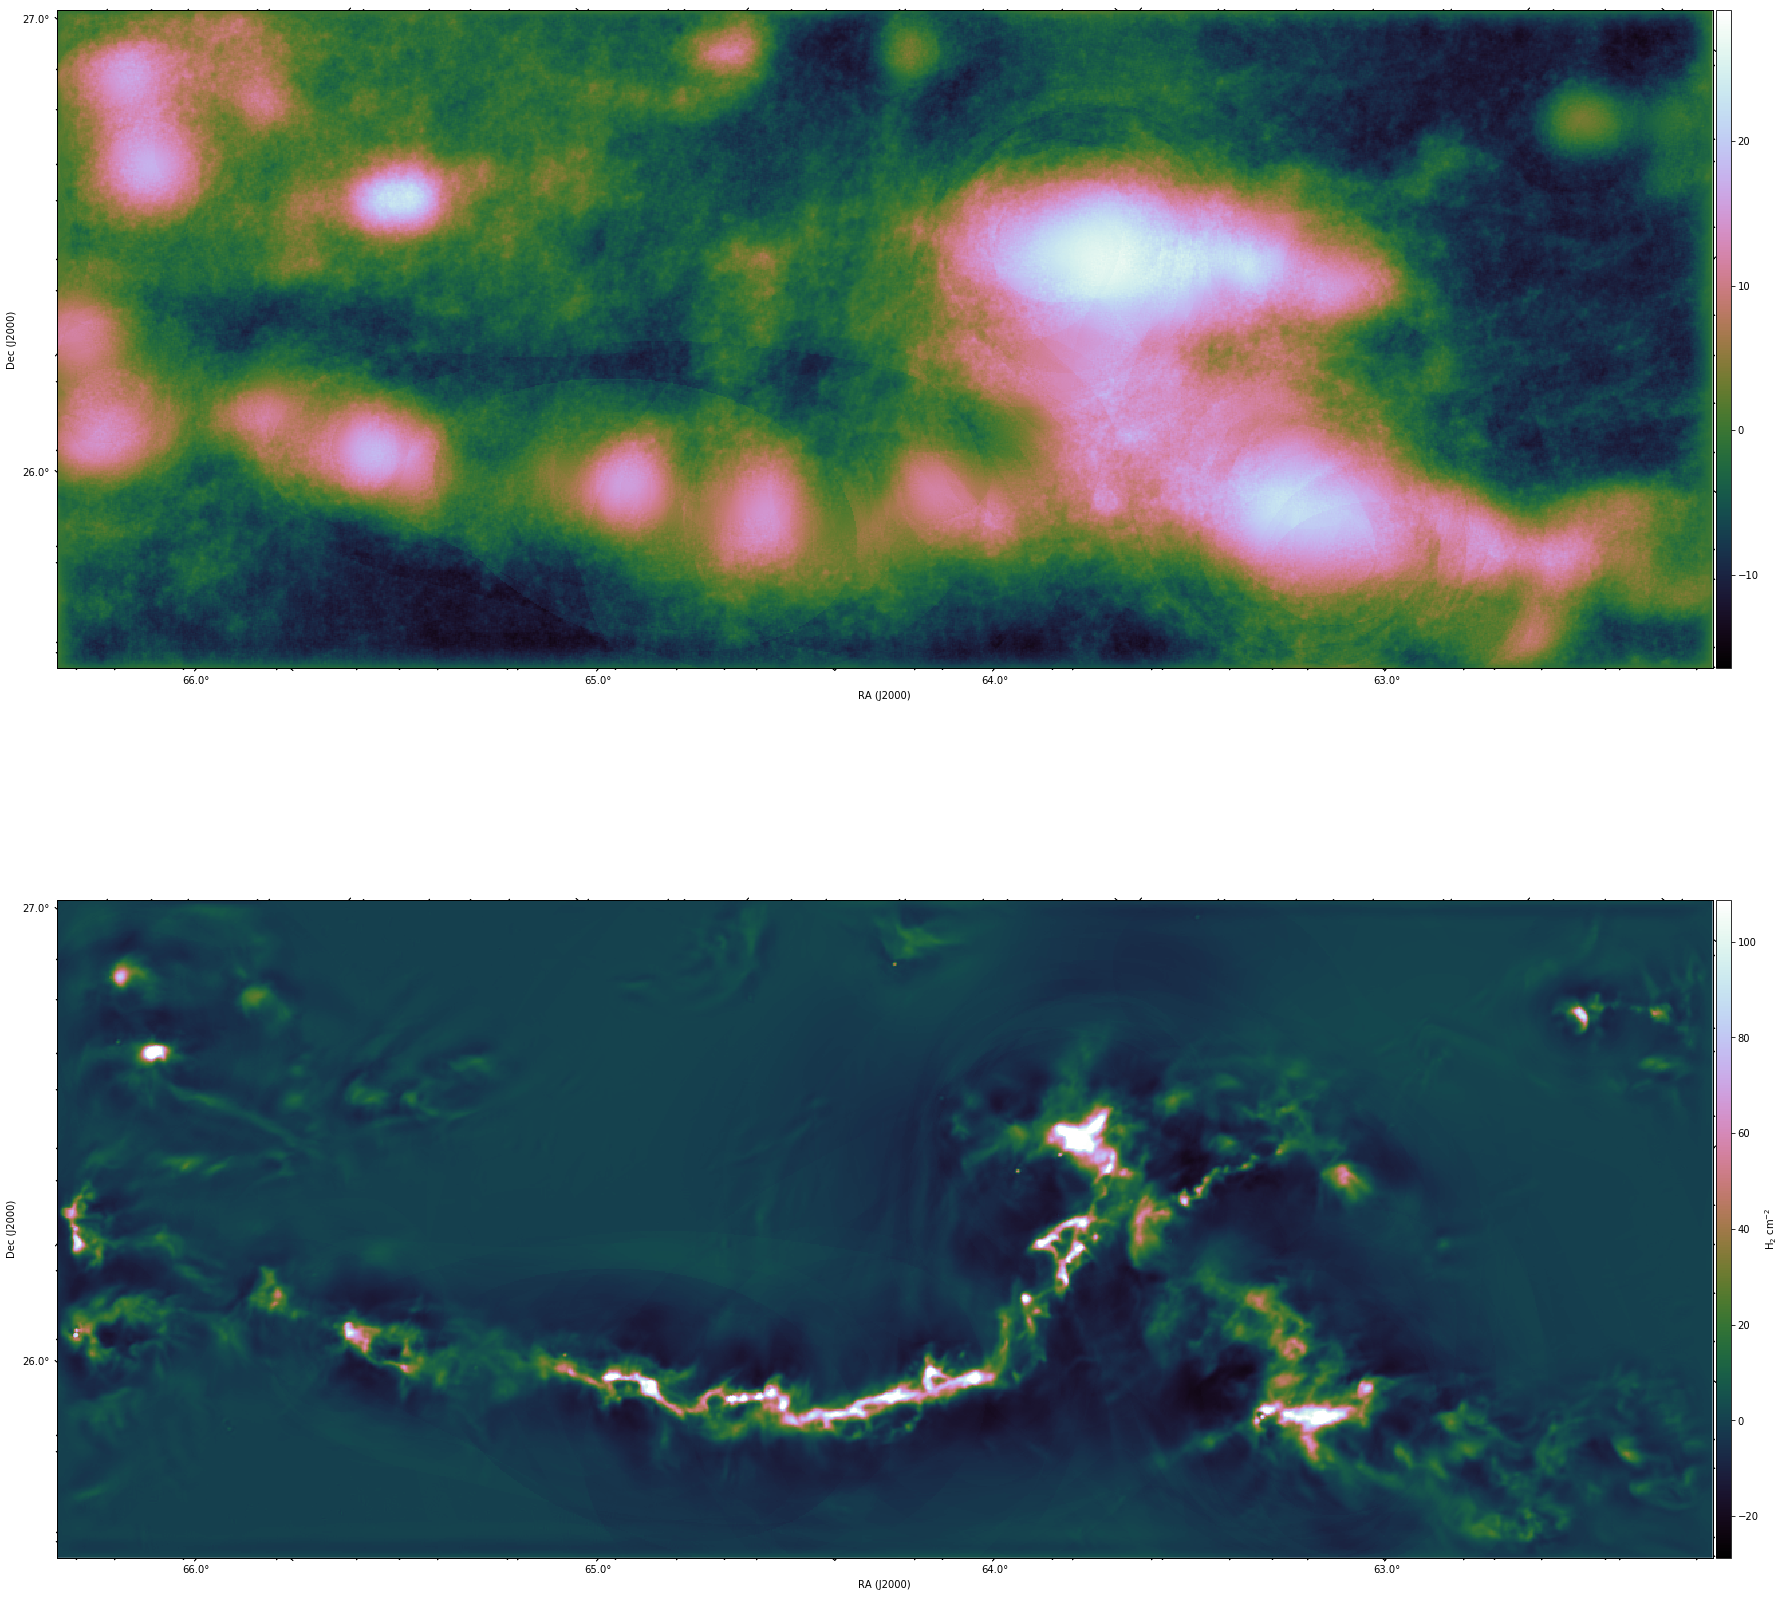

In [154]:
M = wav_k.shape[0]

coherent = np.sum(wts[M:2*M,:,:],axis=0)
Gaussian = np.sum(wts[2*M:3*M,:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Taurus_rbin_cohe.fits',\
            coherent.real,header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Taurus_rbin_gaussian.fits',\
            Gaussian.real,header,overwrite=True)

fig_all = plt.figure(1, figsize=(30,30))

figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Taurus_rbin_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 1, 1))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Taurus_rbin_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 1, 2))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

#plt.subplot(2,2,3)
#imshow(np.sum(wt[2*M+14:2*M+18,:,:],axis=0).real,origin='below')

#plt.subplot(2,2,4)
#imshow(np.sum(wt[M+14:M+18,:,:],axis=0).real,origin='below')

### Smoothed version

In [162]:
#Set a list of q
qm=[]
qm=[2.9]*25
#print q

#Wavelet power spectrum
wtsm, S11asm, wav_k, S1asm, qsm = fan_trans(imzm, reso=reso, q=qm, qdyn=True, skewl=0.6, apodize= 0.98, arrdim = np.array([1500,1500]), smooth=True)

1500 1500


INFO:astropy:Auto-setting vmin to -1.513e+01
INFO:astropy:Auto-setting vmax to  2.834e+01


INFO: Auto-setting vmin to -1.513e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.834e+01 [aplpy.core]


INFO:astropy:Auto-setting vmin to -2.732e+01
INFO:astropy:Auto-setting vmax to  1.036e+02


INFO: Auto-setting vmin to -2.732e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.036e+02 [aplpy.core]


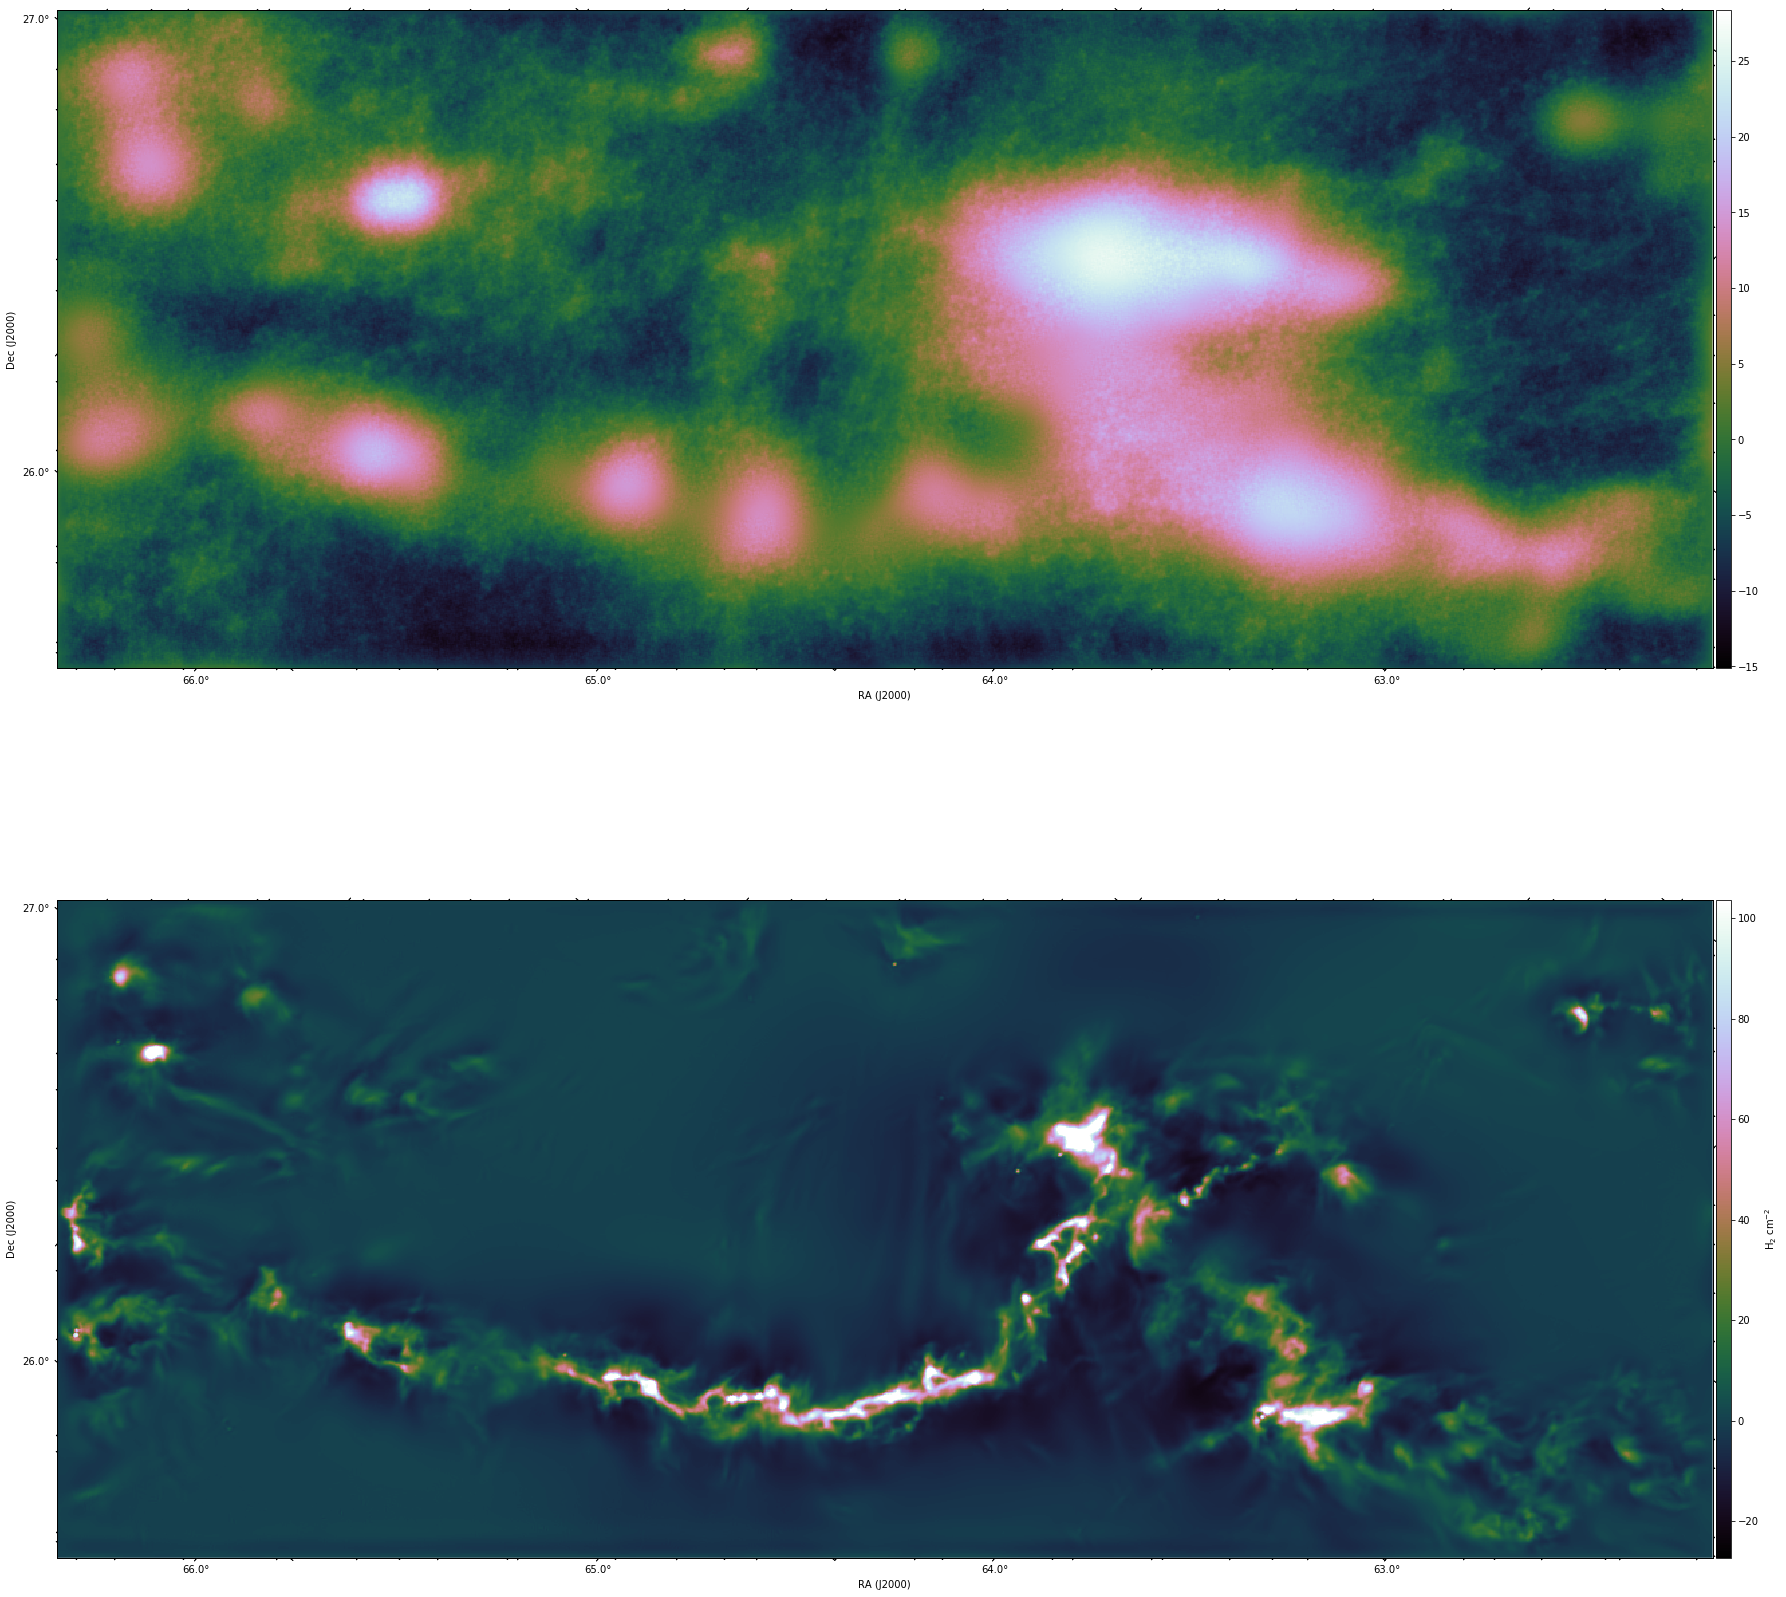

In [164]:
M = wav_k.shape[0]

coherentsm = np.sum(wtsm[M:2*M,:,:],axis=0)
Gaussiansm = np.sum(wtsm[2*M:3*M,:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Taurus_rbin_cohe_smooth.fits',\
            coherentsm.real,header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Taurus_rbin_gaussian_smooth.fits',\
            Gaussiansm.real,header,overwrite=True)

fig_all = plt.figure(1, figsize=(30,30))

figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Taurus_rbin_gaussian_smooth.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 1, 1))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Taurus_rbin_cohe_smooth.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 1, 2))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

#plt.subplot(2,2,3)
#imshow(np.sum(wt[2*M+14:2*M+18,:,:],axis=0).real,origin='below')

#plt.subplot(2,2,4)
#imshow(np.sum(wt[M+14:M+18,:,:],axis=0).real,origin='below')

### Power Spectra Ratio

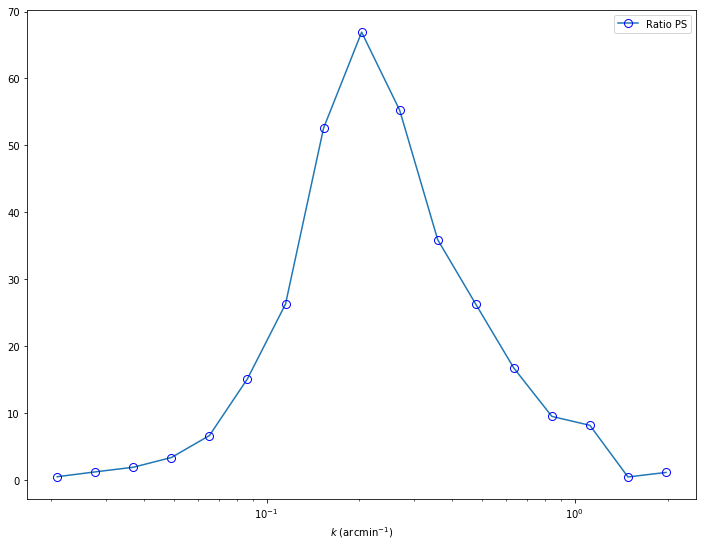

In [159]:
ratio = S1asc[1,:] / S1asc[2,:]

plt.figure(figsize=(12,9))
plt.plot(wav_k[wl:ws], ratio[wl:ws], marker='o', markersize = 8, markerfacecolor='none', markeredgecolor='blue', label=r'Ratio PS')
plt.xscale('log')
plt.xlabel(r"$k$ (arcmin$^{-1}$)")
plt.legend()